This script will show a tradition method of pairwise corr.   
Based on a real data, so preprocessing included.

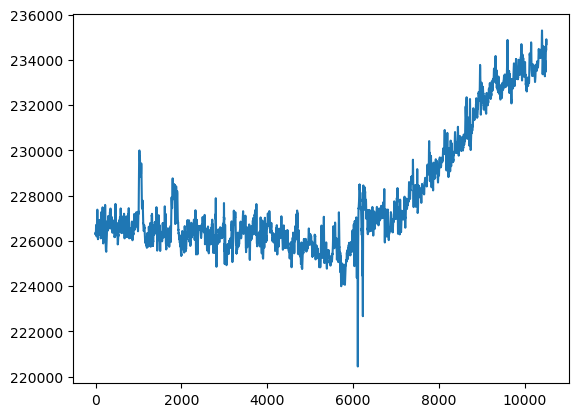

In [1]:
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from Signal_Functions.Filters import Signal_Filter_1D
from scipy import stats
import seaborn as sns
from OI_Functions.VDaQ_dRR_Generator import BLK2DRR
    

wp = r'D:\ZR\_Data_Temp\VDaQ_Data\241015_Niid_Spon\Run03_SPON'
height = 540
width = 654
reader = BLK2DRR(wp)
reader.Read_All_Frames()
r_train = reader.all_graphs.reshape(-1,height,width) # this is raw 
plt.plot(r_train.mean(-1).mean(-1))

As we can see, the global singal have a fuzzy trend.   
We will need detrend for given data.

In [ ]:
# pixel-wise detrend is time costy. Se here we do not re-run.
from scipy.signal import detrend
r_detrend = np.zeros(shape = (len(r_train),height,width),dtype='f8')
for i in tqdm(range(height)):
    for j in range(width):
        x = r_train[:,i,j]

        degree = 4 # poly of detrend function
        # Fit a polynomial to the data
        coefficients = np.polyfit(range(len(x)),x, degree)
        # Generate the polynomial trend line
        trend = np.polyval(coefficients, range(len(x)))
        # plt.plot(x)
        # plt.plot(x-trend)
        r_detrend[:,i,j] = (x-trend)+coefficients[-1] # add back DC comps

cf.Save_Variable(wp,'R_detrend',r_detrend)


In [9]:
# another method to detrend, we use only filters here.
from Signal_Functions.Filters import  Signal_Filter_1D

HP_freq = 0.005
LP_freq = 1
fps = 4
r_filted = np.zeros(shape = (len(r_train),height,width),dtype='f8')

for i in tqdm(range(height)):
    for j in range(width):
        x = r_train[:,i,j]
        filted_x = Signal_Filter_1D(x,HP_freq,LP_freq,fps)
        r_filted[:,i,j] = filted_x

cf.Save_Variable(wp,'R_filted',r_filted)

100%|██████████| 540/540 [13:30<00:00,  1.50s/it]


True

---
Using detrended R series, we provide 2 method of seed point corr.   
Method 1, give the coords and radius of seeds.   
Method 2, give the seed mask to get correlation.   
Both are done in window-slide way. you can change the winsize, set 9999999 as no-win

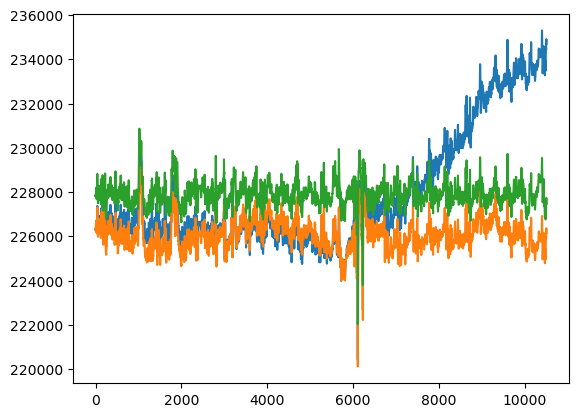

In [10]:
# show data before and after detrend.
r_detrend = cf.Load_Variable(wp,'R_detrend.pkl')
r_filted = cf.Load_Variable(wp,'R_filted.pkl')
plt.plot(r_train.mean(-1).mean(-1))
plt.plot(r_detrend.mean(-1).mean(-1))
plt.plot(r_filted.mean(-1).mean(-1))
global_avr = r_train.mean(0)
del r_train

Use global mean as R0, and generate dRR matrix.   


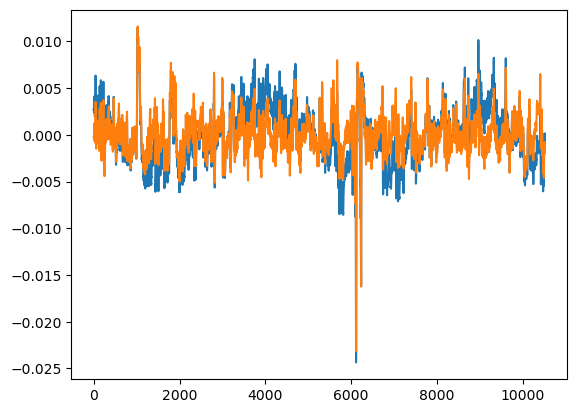

In [11]:
drr_train_detrend = r_detrend/r_detrend.mean(0)-1
drr_train_filted = r_filted/r_filted.mean(0)-1
plt.plot(drr_train_detrend.mean(-1).mean(-1))
plt.plot(drr_train_filted.mean(-1).mean(-1))
# as we can see, not 

In [13]:
drr_train_filted.shape

(10510, 540, 654)

---
#### Method 1, From given coords.   
If you know the coords of seed location and want to give the radius, you can use this function.   
You need to provide:    
1. Coords
2. radius of seed
3. winsize

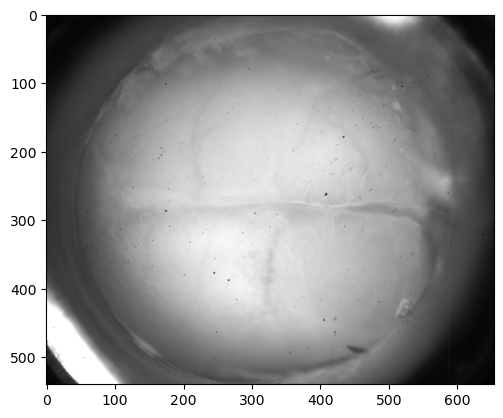

In [12]:
plt.imshow(global_avr,cmap='gray')

In [18]:
# give the coords of seed and radius of seed, the you can just get filted matrix
from Seed_Functions import *
win_len = 2400
win_step = 1200


seed_coords = (230,175) # height,width
r = 10 # radius of seed circle.
seed_mask = Generate_Circle_Mask(seed_coords,r,540,654)
corr_wins = Seed_Window_Slide(seed_mask,drr_train_filted,win_len,win_step)

100%|██████████| 16/16 [21:35<00:00, 81.00s/it]


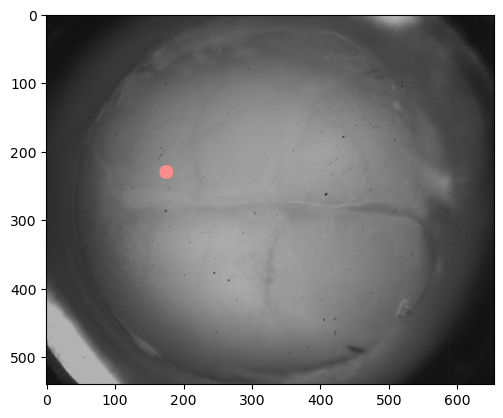

In [78]:
# show mask on avr graph.
mask_graph = np.zeros(shape = (540,654,3))
normed_avr = global_avr/global_avr.max()*255

for i in range(3):
    mask_graph[:,:,i] = normed_avr*0.7

mask_graph[:,:,0] += seed_mask*255
mask_graph = np.clip(mask_graph,0,255)

plt.imshow(mask_graph.astype('u1'))

In [19]:
savepath = cf.join(wp,'Corrs')
cf.mkdir(savepath)
for i in range(len(corr_wins)):
    c_corr = corr_wins[i,:,:]
    plt.clf()
    # plt.cla()
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 240)
    sns.heatmap(c_corr,xticklabels=False,yticklabels=False,square=True,ax = ax,center=0.7,vmax = 1,vmin =0.3)
    fig.savefig(cf.join(savepath,f'{10000+i}.png'))
    plt.close(fig)



Folder D:\ZR\_Data_Temp\VDaQ_Data\241015_Niid_Spon\Run03_SPON\Corrs already exists!


<Figure size 640x480 with 0 Axes>

<AxesSubplot: >

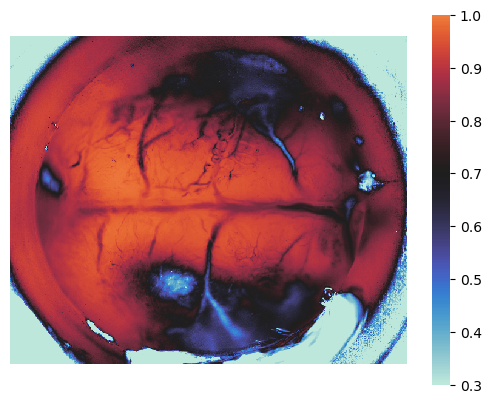

In [41]:
# show example of corr
sns.heatmap(corr_wins[15,:,:],xticklabels=False,yticklabels=False,square=True,center=0.7,vmax = 1,vmin = 0.3)

---
If you want to plot avr subtracted results...

In [25]:

global_mean = drr_train_filted.mean(-1).mean(-1)
drr_train_subtracted = drr_train_filted-global_mean[:, np.newaxis, np.newaxis] # global subtracted results.

corr_wins_cen_sub = Seed_Window_Slide(seed_mask,drr_train_subtracted,win_len,win_step)



100%|██████████| 16/16 [21:06<00:00, 79.13s/it]


In [26]:
savepath = cf.join(wp,'Center_Sub_Corrs')
cf.mkdir(savepath)

for i in range(len(corr_wins)):
    c_corr = corr_wins_cen_sub[i,:,:]
    plt.clf()
    # plt.cla()
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 240)
    sns.heatmap(c_corr,xticklabels=False,yticklabels=False,square=True,ax = ax,center=0,vmax = 1,vmin = -1)
    fig.savefig(cf.join(savepath,f'{10000+i}.png'))
    plt.close(fig)


cf.Save_Variable(savepath ,'Censub_Corr',corr_wins_cen_sub)

<Figure size 640x480 with 0 Axes>

<AxesSubplot: >

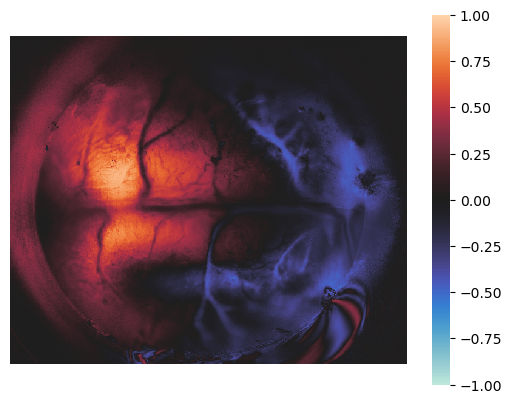

In [42]:
# show example of corr
sns.heatmap(corr_wins_cen_sub[15,:,:],xticklabels=False,yticklabels=False,square=True,center=0,vmax = 1,vmin = -1)

---
#### Method 2, from mask
Actually more easier.   
You need to provide:    
1. Mask matrix
2. Winsize

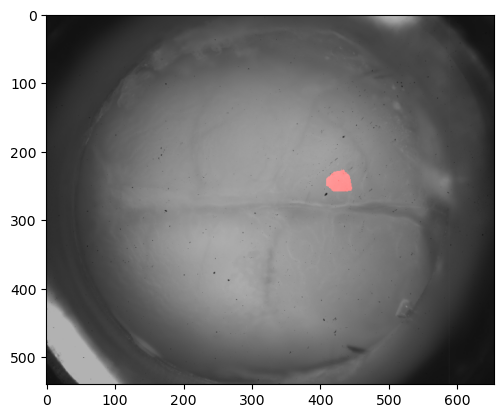

In [79]:
# load in mask
import cv2
img_mask = cv2.imread(cf.join(wp,'Example_Mask.bmp'),0)>128


# show mask on graph.
mask_graph = np.zeros(shape = (540,654,3))
normed_avr = global_avr/global_avr.max()*255
for i in range(3):
    mask_graph[:,:,i] = normed_avr*0.7

mask_graph[:,:,0] += img_mask*255
mask_graph = np.clip(mask_graph,0,255)
plt.imshow(mask_graph.astype('u1'))

In [30]:
# then the same as normal methods.
corr_wins_cen_sub_img = Seed_Window_Slide(img_mask,drr_train_subtracted,win_len,win_step)

savepath = cf.join(wp,'Img_Masks')
cf.Save_Variable(savepath ,'Img_Mask_Corr',corr_wins_cen_sub_img)


cf.mkdir(savepath)

for i in range(len(corr_wins)):
    c_corr = corr_wins_cen_sub_img[i,:,:]
    plt.clf()
    # plt.cla()
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 240)
    sns.heatmap(c_corr,xticklabels=False,yticklabels=False,square=True,ax = ax,center=0,vmax = 1,vmin = -1)
    fig.savefig(cf.join(savepath,f'{10000+i}.png'))
    plt.close(fig)


100%|██████████| 16/16 [21:21<00:00, 80.09s/it]


Folder D:\ZR\_Data_Temp\VDaQ_Data\241015_Niid_Spon\Run03_SPON\Img_Masks already exists!


<Figure size 640x480 with 0 Axes>

<AxesSubplot: >

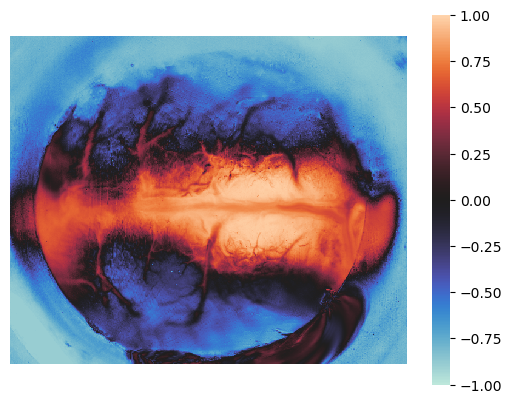

In [43]:
# show example of corr

sns.heatmap(corr_wins_cen_sub_img[15,:,:],xticklabels=False,yticklabels=False,square=True,center=0,vmax = 1,vmin = -1)